In [ ]:
!pip install -U ann_visualizer
!pip install -U ggplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=a277d218a0a08dcfccdb55964ad89ff6847a538b9e2060bca51b5494f8846519
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.1 MB/s eta 0:00:00


In [ ]:
import random
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

from ann_visualizer.visualize import ann_viz;
from sklearn.tree import export_graphviz
import graphviz

from matplotlib.pyplot import imread
import matplotlib
import numpy as np
import os
import imageio
import cv2
from random import seed
seed(42)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import tensorflow
import keras
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.initializers import he_normal
from keras.preprocessing import image
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout, Input
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras import backend as K

from numpy.testing import assert_allclose
import nibabel as nib
from nibabel.testing import data_path
from PIL import Image
#import nilearn
#from nilearn import image, plotting
#import ggplot
#from ggplot import aes, geom_point, ggtitle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/oasis_cross-sectional.csv")
data.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [ ]:
data['CDR'].value_counts()

0.0    135
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

In [ ]:
print('Data types:\n', data.dtypes)

Data types:
 ID        object
M/F       object
Hand      object
Age        int64
Educ     float64
SES      float64
MMSE     float64
CDR      float64
eTIV       int64
nWBV     float64
ASF      float64
Delay    float64
dtype: object


In [ ]:
print('Missing values:\n', data.isnull().sum())

Missing values:
 ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64


In [ ]:
print('Descriptive statistics:\n', data.describe())

Descriptive statistics:
               Age        Educ         SES       MMSE         CDR         eTIV  \
count  436.000000  235.000000  216.000000  235.00000  235.000000   436.000000   
mean    51.357798    3.178723    2.490741   27.06383    0.285106  1481.919725   
std     25.269862    1.311510    1.120593    3.69687    0.383405   158.740866   
min     18.000000    1.000000    1.000000   14.00000    0.000000  1123.000000   
25%     23.000000    2.000000    2.000000   26.00000    0.000000  1367.750000   
50%     54.000000    3.000000    2.000000   29.00000    0.000000  1475.500000   
75%     74.000000    4.000000    3.000000   30.00000    0.500000  1579.250000   
max     96.000000    5.000000    5.000000   30.00000    2.000000  1992.000000   

             nWBV         ASF     Delay  
count  436.000000  436.000000  20.00000  
mean     0.791670    1.198894  20.55000  
std      0.059937    0.128682  23.86249  
min      0.644000    0.881000   1.00000  
25%      0.742750    1.111750   2.7

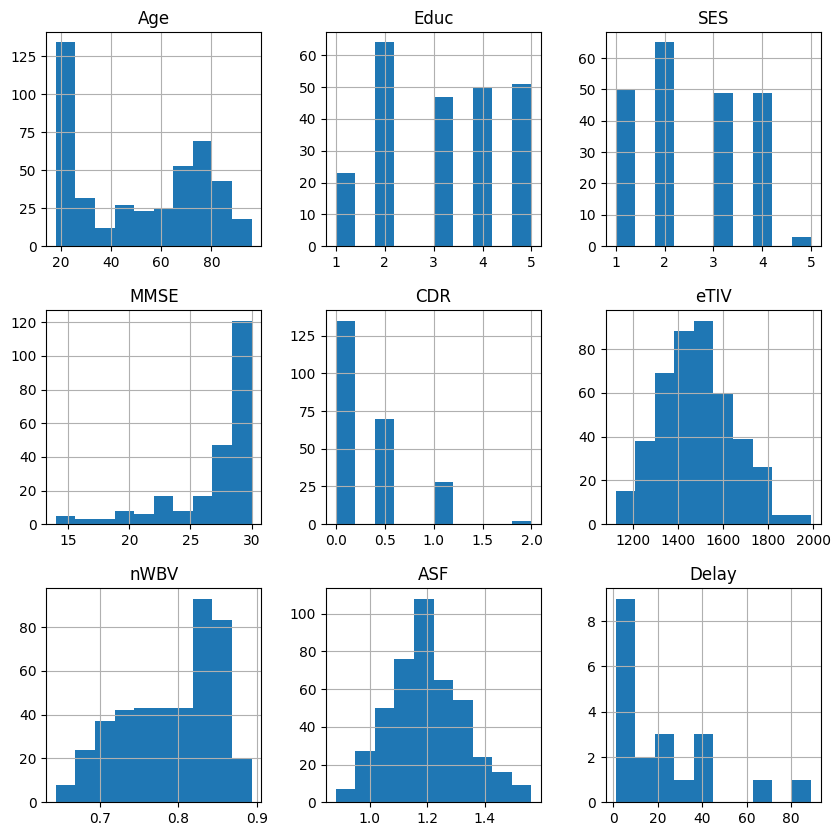

In [ ]:
data.hist(figsize=(10,10))
plt.show()

<ipython-input-9-48cdfd721cbb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='coolwarm', annot=True)


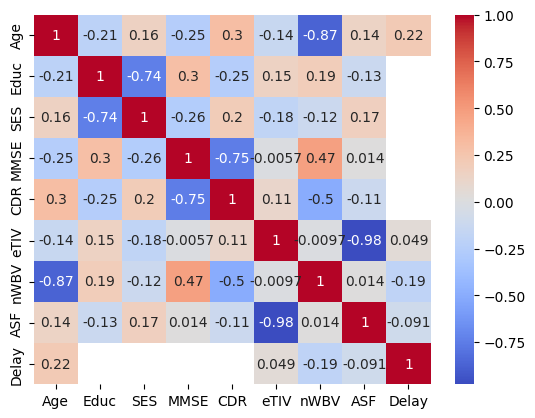

In [ ]:
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
plt.show()

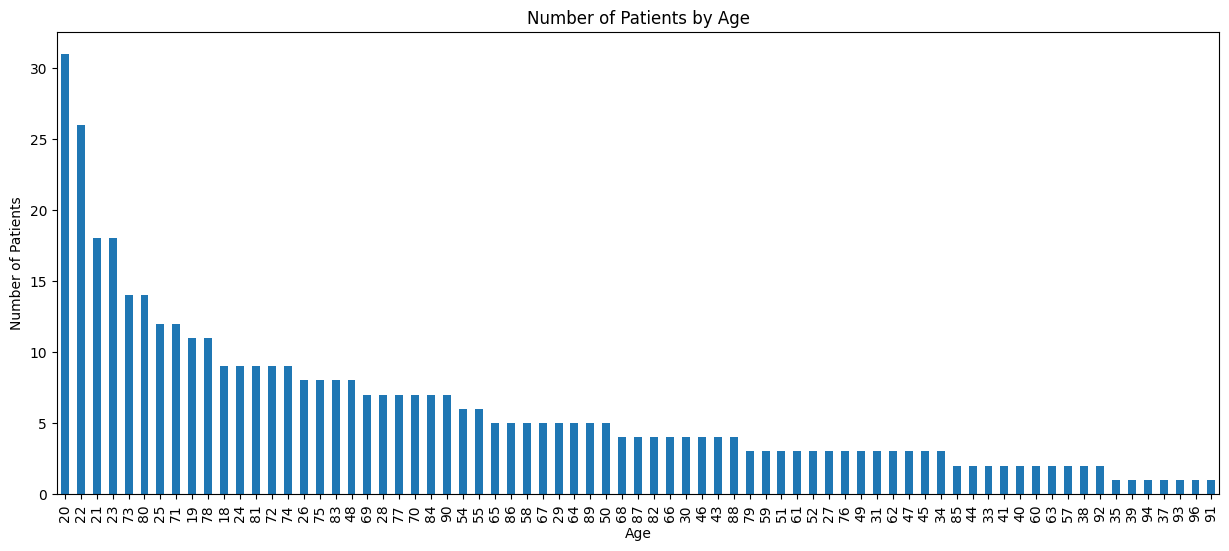

In [ ]:
# Count the number of patients for each age
age_counts = data['Age'].value_counts()
plt.figure(figsize=(15, 6))
age_counts.plot(kind='bar')

# Set plot title and axis labels
plt.title('Number of Patients by Age')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.show()


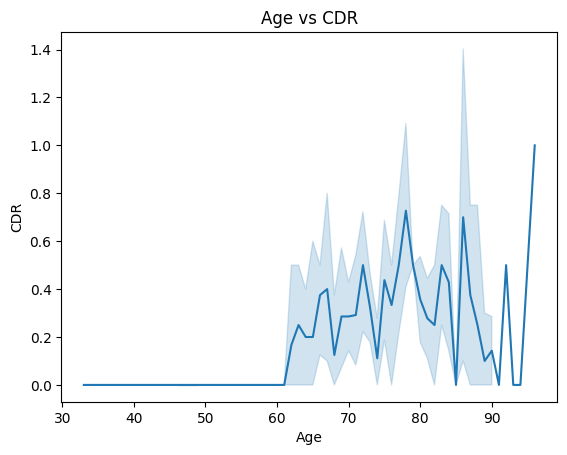

In [ ]:
#Age vs CDR for all patients
sns.lineplot(x='Age', y='CDR', data=data)
plt.title('Age vs CDR')
plt.show()

In [ ]:
# Filtering dataset to males and females
df_females = data[data['M/F'] == 'F']
df_males = data[data['M/F'] == 'M']

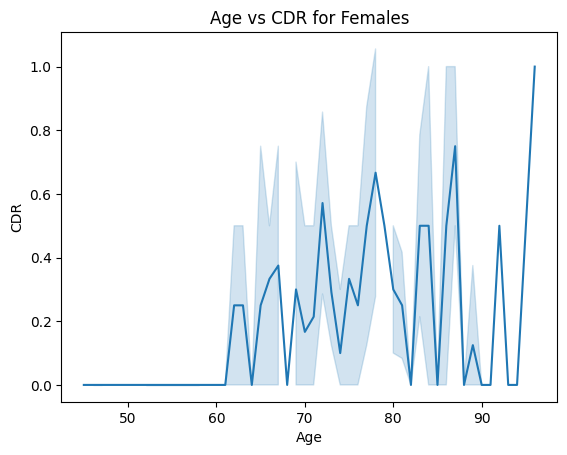

In [ ]:
# Creating a line plot of Age versus CDR for females only
sns.lineplot(x='Age', y='CDR', data=df_females)
plt.title('Age vs CDR for Females')
plt.show()

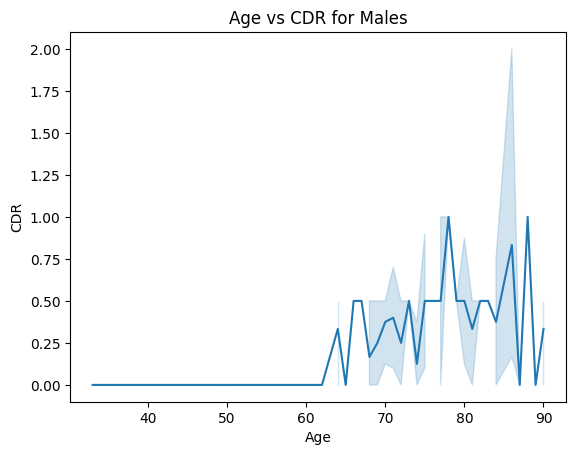

In [ ]:
#Age versus CDR for males only
sns.lineplot(x='Age', y='CDR', data=df_males)
plt.title('Age vs CDR for Males')
plt.show()

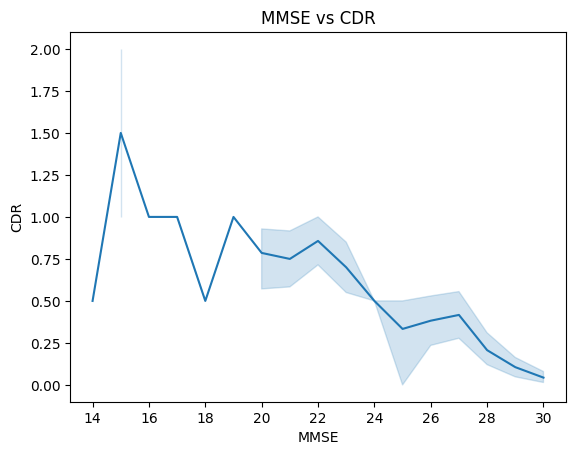

In [ ]:
sns.lineplot(x='MMSE', y='CDR', data=data)
plt.title('MMSE vs CDR')
plt.show()

In [ ]:
# Group the data by a categorical variable and compute summary statistics for each group
#M/F: Gender, Educ: Education level
grouped_df = data.groupby('M/F').agg({'Age': ['mean', 'median', 'std'], 'Educ': ['mean', 'median', 'std']})
print(grouped_df)

           Age                        Educ                 
          mean median        std      mean median       std
M/F                                                        
F    53.369403   58.0  25.253058  3.115385    3.0  1.279927
M    48.148810   46.0  25.037849  3.303797    4.0  1.371453


In [ ]:
# Replace missing data with mean values
data.fillna(data.mean(), inplace=True)

<ipython-input-17-5802addebc1f>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


In [ ]:
# Check for missing values again to ensure they have been filled
print('Missing values after filling:\n', data.isnull().sum())

Missing values after filling:
 ID       0
M/F      0
Hand     0
Age      0
Educ     0
SES      0
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
Delay    0
dtype: int64


In [ ]:
# Drop unnecessary columns
data.drop(['ID', 'Hand'], axis=1, inplace=True)

# Print the updated DataFrame
print(data.head())

  M/F  Age      Educ       SES      MMSE       CDR  eTIV   nWBV    ASF  Delay
0   F   74  2.000000  3.000000  29.00000  0.000000  1344  0.743  1.306  20.55
1   F   55  4.000000  1.000000  29.00000  0.000000  1147  0.810  1.531  20.55
2   F   73  4.000000  3.000000  27.00000  0.500000  1454  0.708  1.207  20.55
3   M   28  3.178723  2.490741  27.06383  0.285106  1588  0.803  1.105  20.55
4   M   18  3.178723  2.490741  27.06383  0.285106  1737  0.848  1.010  20.55


In [ ]:
# Convert the 'gender' column to numerical
gender_dummies = pd.get_dummies(data['M/F'], prefix='Sex')
data = pd.concat([data, gender_dummies], axis=1)
data.drop(['M/F'], axis=1, inplace=True)
data.head()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Sex_F,Sex_M
0,74,2.000000,3.000000,29.00000,0.000000,1344,0.743,1.306,20.55,1,0
1,55,4.000000,1.000000,29.00000,0.000000,1147,0.810,1.531,20.55,1,0
2,73,4.000000,3.000000,27.00000,0.500000,1454,0.708,1.207,20.55,1,0
3,28,3.178723,2.490741,27.06383,0.285106,1588,0.803,1.105,20.55,0,1
4,18,3.178723,2.490741,27.06383,0.285106,1737,0.848,1.010,20.55,0,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
data['CDR_class'] = data['CDR'].apply(lambda x: 1 if x >= 0.5 else 0)
X_CS = data.drop(['CDR', 'CDR_class'], axis=1)
y_CS = data['CDR_class']

In [ ]:
X_trainCS, X_testCS, y_trainCS, y_testCS = train_test_split(X_CS, y_CS, test_size=0.3)

In [ ]:
X_trainCS.shape, X_testCS.shape, y_trainCS.shape, y_testCS.shape

((305, 10), (131, 10), (305,), (131,))

In [ ]:
y_trainCS = y_trainCS.values.ravel()
y_trainCS.shape

(305,)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)

In [ ]:
clf.fit(X_trainCS, y_trainCS)

KNeighborsClassifier()

In [ ]:
y_predCS = clf.predict(X_testCS)

In [ ]:
# Evaluate the model's accuracy on the test data
accuracy = clf.score(X_testCS, y_testCS)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7633587786259542


**Working with fMRI data**

**"get_slice()" function reads in MRI data from multiple disks located in a directory and generates a list of brain images for input to a neural network. It also creates a list of all subjects included in the study for diagnosis labeling later.**

In [ ]:
def get_slice():                                                                              # read in OASIS-1 MRI data across discs
    path = '/content/drive/MyDrive/Oasis/Disks'
    disc_list = os.listdir(path)                                                              # get list of discs from directory
    Windows_file = 'Thumbs.db'
    if Windows_file in disc_list:
        disc_list.remove(Windows_file)                                                        # remove Windows file if any

    brain_list, total_subjects = [], [] # generate list of brain images for input to NN, all subjects used in study
    
    for disc in disc_list:
        path_ind_disc = f'{path}/{disc}'
        subject_list_p_disc = os.listdir(path_ind_disc)                                        # generate list of subjects in each disc
        if Windows_file in subject_list_p_disc:
            subject_list_p_disc.remove(Windows_file)                                           # remove Windows file
            
        for subj_id in subject_list_p_disc:
            total_subjects.append(subj_id)                                                # maintain a list of all subjects included in study for diagnosis labeling later
    
            path_n4 = path_ind_disc + f'/{subj_id}/RAW/{subj_id}_mpr-3_anon_sag_66.gif'
            #path_n3 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            #path_n6 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            #path_n5 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            
            path_list = [path_n4]
            for i in path_list:
                if os.path.exists(i) == True:
                    brain_list.append(plt.imread(i)) # append if file format exists

    return disc_list, brain_list, total_subjects

In [ ]:
disc_list, brain_list, total_subjects = get_slice()

In [ ]:
disc_list = disc_list[0:6]

In [ ]:
disc_list

['disc1', 'disc2', 'disc3', 'disc4', 'disc10', 'allimages']

In [ ]:
len(total_subjects)

183

In [ ]:
brain_list

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0

**"get_diagnosis(total_subjects)" function reads in a summary file, converts diagnosis to labels, extracts subject ID from MR ID, and creates a dictionary of subjects and diagnoses. It returns a dataframe of subjects and their corresponding diagnoses and a diagnosis dictionary.**

In [ ]:
def get_diagnosis(total_subjects):                                                    # builds a dictionary of subjects and diagnoses
    oasis1 = pd.read_csv('/content/drive/MyDrive/oasis_cross-sectional.csv')                                 # read in summary file
    oasis1['CDR'].fillna(0, inplace=True)                                             # null values are healthy diagnoses
    diagnosis_qual={0.:'normal', 0.5:'AD', 1.:'AD', 2.:'AD' }                         # convert diagnosis to labels
    oasis1.replace({"CDR": diagnosis_qual}, inplace=True)
    diagnosis_quant={'normal':0,'AD':1}                                               # convert diagnosis to numerical values
    oasis1.replace({"CDR": diagnosis_quant}, inplace=True)
    oasis1['Subject'] =pd.DataFrame([subj[0:9] for subj in oasis1['ID']])             # extract subject ID from MR ID
    
    subjects = [subj[0:9] for subj in total_subjects]                                 # get subject names for each MRI ID
    subjects = pd.DataFrame(subjects, columns = ['Subject'])                          # convert to dataframe
    
    diagnosis_dict= {oasis1['Subject'][num]: oasis1['CDR'][num] for num in range(0, 148)} # create a dictionary with subject and diagnosis
    diag = [diagnosis_dict[subj] for subj in subjects['Subject']]                     # create a list of diagnoses to append to dataframe of subjects
    subjects['Diagnosis'] = pd.DataFrame(diag)
    
    return subjects, diagnosis_dict

In [ ]:
subjects, diagnosis_dict = get_diagnosis(total_subjects)

**"balance_set(subjects, total_subjects, disc_list)" function balances the data by upsampling the number of AD (Alzheimer's disease) subjects and appends the corresponding MRIs to the brain_list. It also updates the list of all subjects included in the study. It returns a numpy array of brain images and a dataframe of subjects diagnosed with AD.**

**Overall, these functions are responsible for reading in, processing, and balancing the medical imaging data and creating a dataset of subjects and their diagnoses.**

In [ ]:
def balance_set(subjects, total_subjects, disc_list): # balance the data
    AD_subjects = subjects.sort_values(by='Diagnosis', ascending = False).head(97) # all subjects diagnosed as AD
    AD_subjects = AD_subjects.append(AD_subjects)
    head = AD_subjects.head(42) # upsample to balance
    AD_subjects = AD_subjects.append(head)    
    
    for subj in AD_subjects['Subject']:
        total_subjects.append(str(subj) + '_MR1') # maintain a list of all subjects included in study for diagnosis labeling later
    for disc in disc_list:
            path = f'Discs/{disc}'

            for i in AD_subjects['Subject']:

                path_n4 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                #path_n3 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                #path_n6 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                #path_n5 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'

                path_list = [path_n4]                #path_list = [path_n4, path_n3, path_n6, path_n5]
                for i in path_list:
                    if os.path.exists(i) == True:
                        brain_list.append(plt.imread(i)) # append if file format exists

    brain_array = np.asarray(brain_list)
    return brain_array, AD_subjects

In [ ]:
brain_array, AD_subjects = balance_set(subjects, total_subjects, disc_list) 
subjects, diagnosis_dict = get_diagnosis(total_subjects)

<ipython-input-13-e37a88865b2d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AD_subjects = AD_subjects.append(AD_subjects)
<ipython-input-13-e37a88865b2d>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AD_subjects = AD_subjects.append(head)


In [ ]:
print(brain_array.shape)

(148, 256, 256)


                                  Test Images                                   


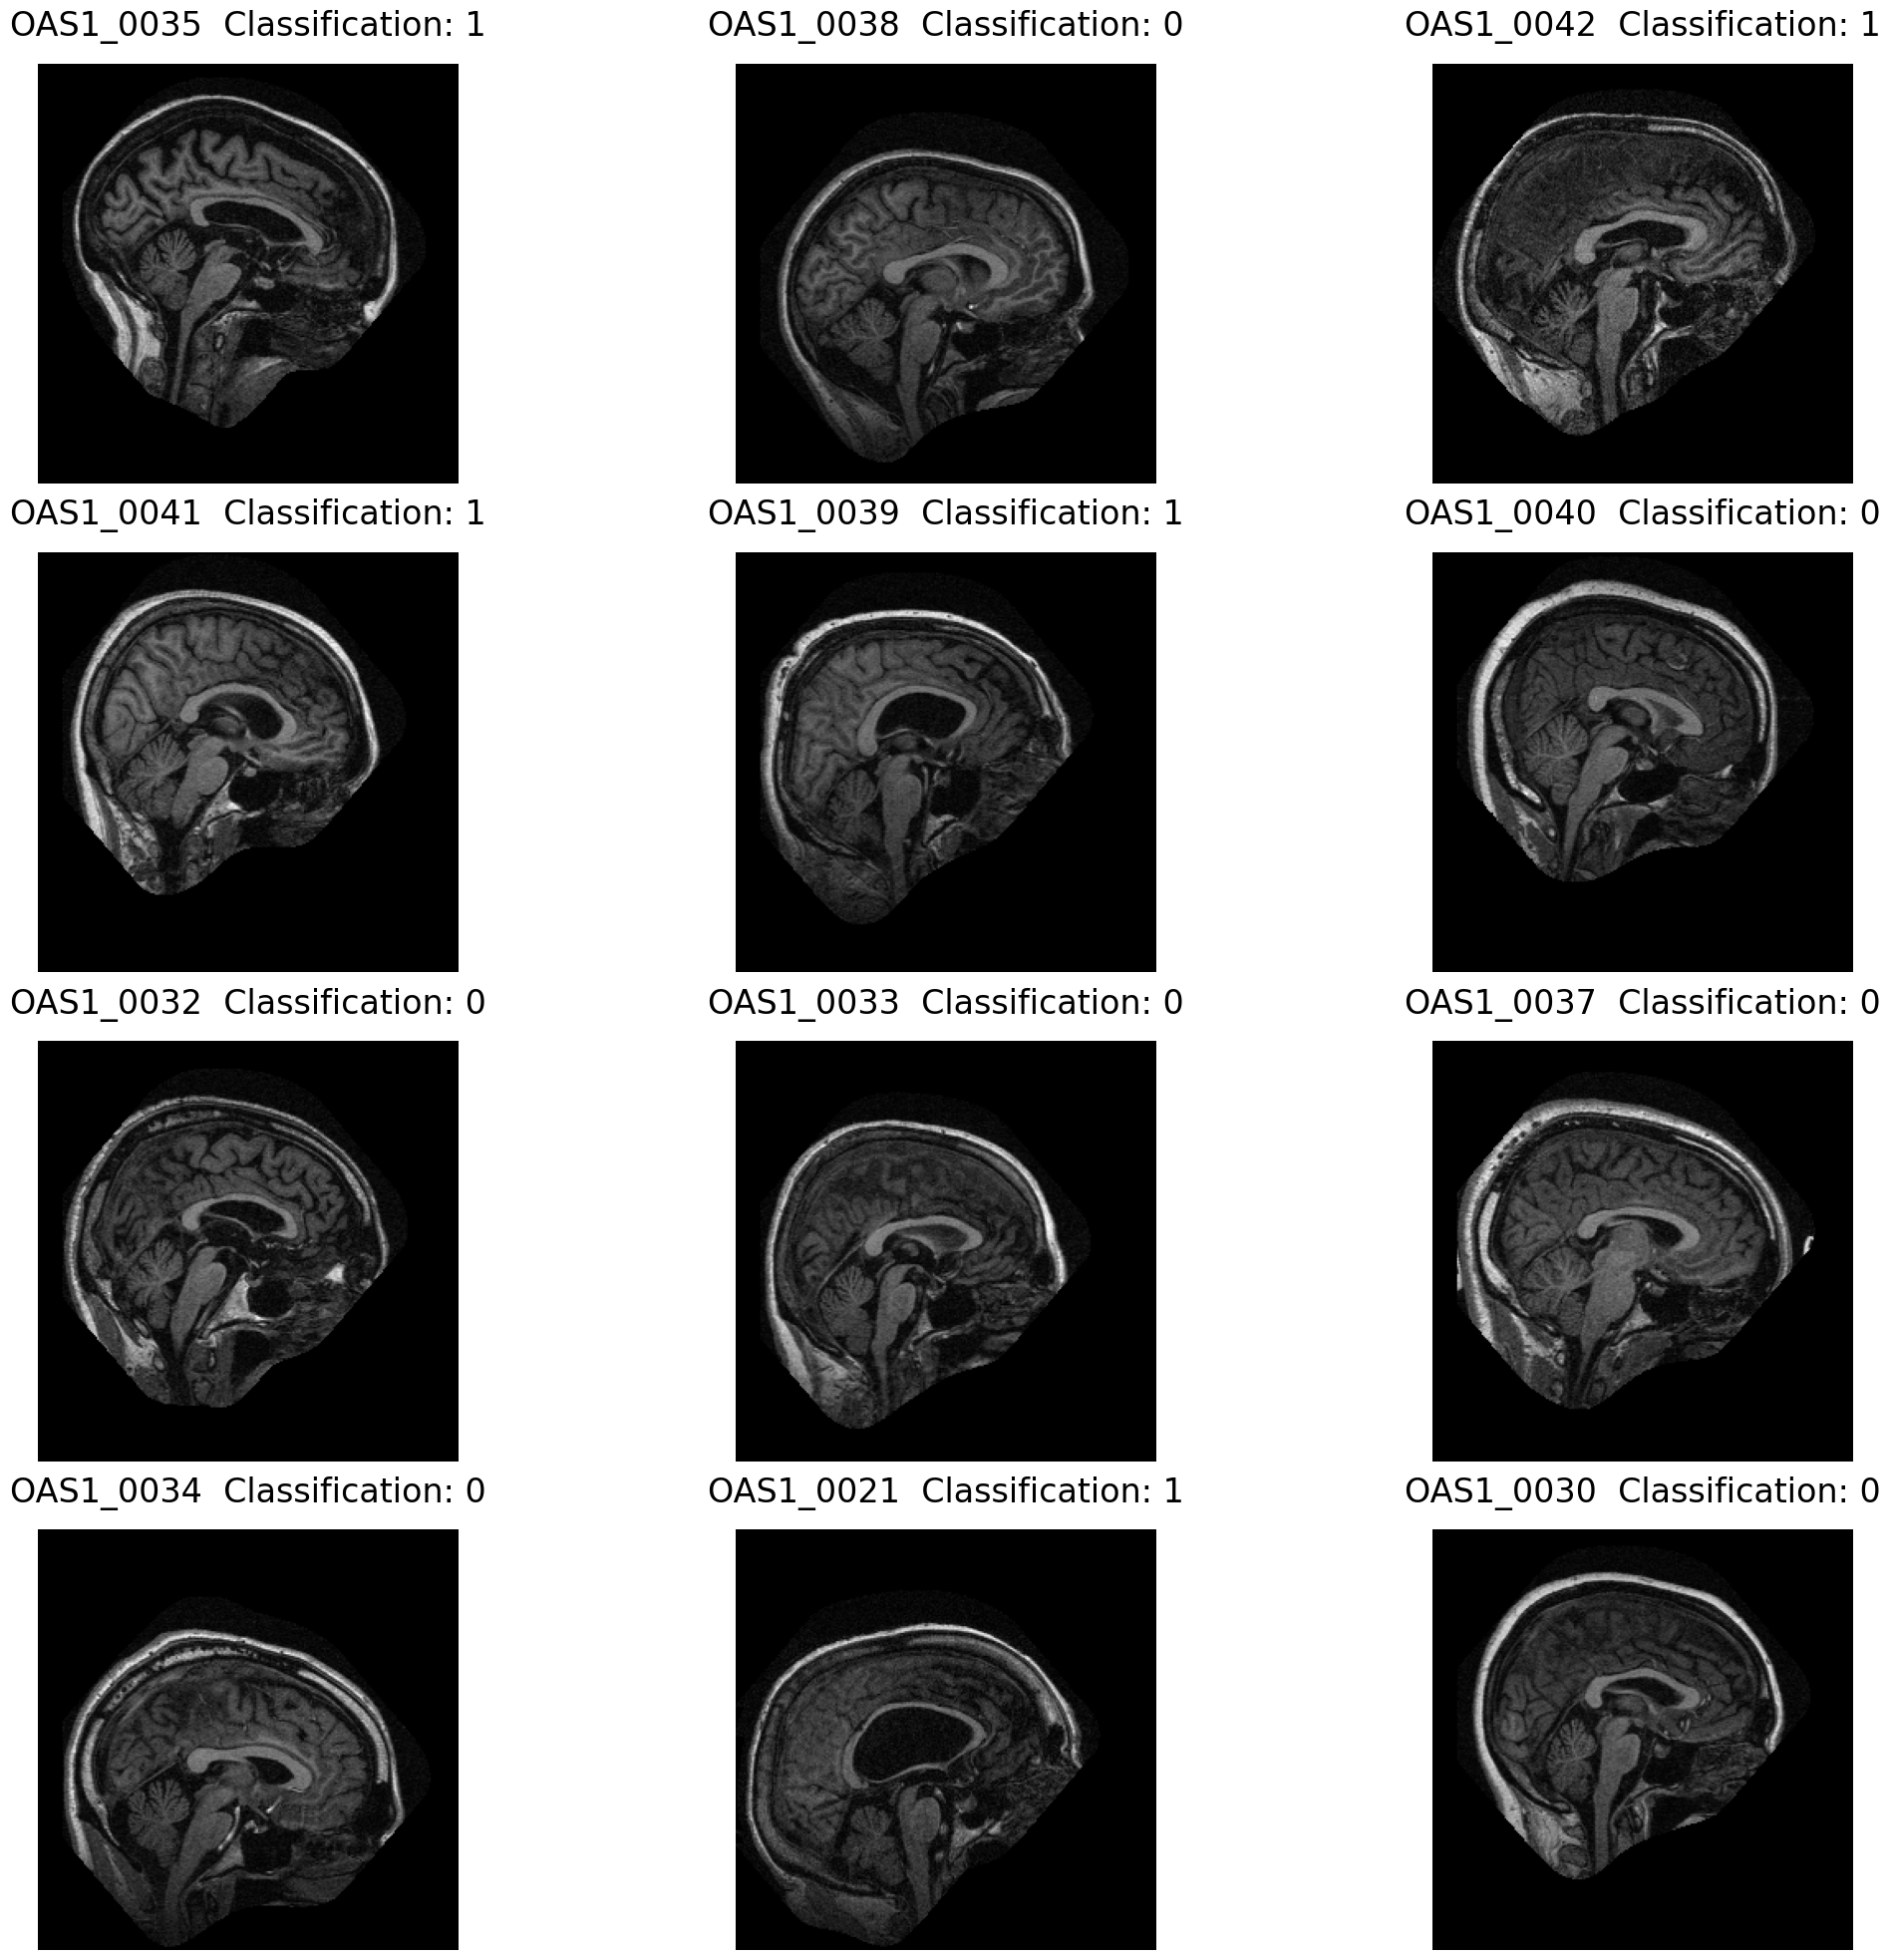

In [ ]:
def plot_test_images(subject, diagnosis, array):
    plt.figure(figsize = (20, 20))
    print("Test Images".center(80))
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.title(str(subject[i]) +'  Classification: ' + str(diagnosis[i]), fontsize=24, pad = 20)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(array[i], cmap = 'gray')
        plt.subplots_adjust(wspace = 0.25)
    plt.show()  

plot_test_images(subjects['Subject'], subjects['Diagnosis'], brain_array)

In [ ]:
#To get only unique values

# get the list of subject IDs that are in the brain_array variable
brain_array_subjects = np.unique(subjects['Subject'])

# get the list of subject IDs that are in the subjects variable
subjects_list = subjects['Subject'].tolist()

# find the IDs that are in the subjects variable but not in the brain_array variable
subjects_to_remove = set(subjects_list) - set(brain_array_subjects)

# drop the rows from the subjects variable that correspond to the IDs to be removed
subjects = subjects[~subjects['Subject'].isin(subjects_to_remove)]


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(brain_array, subjects['Diagnosis'][:148], test_size=0.3, random_state=42)

# Split the training data further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


In [ ]:
x_MRI = brain_array # array of image values
y_MRI = np.asarray(subjects['Diagnosis'][:148]) # diagnosis for each subject
x_MRI = x_MRI.reshape(-1, 256, 256,1)

norm = lambda x :(x - np.min(x)) / (np.max(x) - np.min(x)) # normalize x values
x_MRI_norm = norm(x_MRI)
assert (np.min(x_MRI_norm), np.max(x_MRI_norm)) == (0.0, 1.0) # check min and max values

# check if the number of samples in x_MRI_norm and y_MRI are equal
if x_MRI_norm.shape[0] != y_MRI.shape[0]:
    print("Number of samples in x_MRI_norm and y_MRI are not equal. Removing samples without labels...")
    idx_to_remove = np.where(np.isnan(y_MRI))
    x_MRI_norm = np.delete(x_MRI_norm, idx_to_remove, axis=0)
    y_MRI = np.delete(y_MRI, idx_to_remove)

x_MRI_train, x_MRI_test, y_MRI_train, y_MRI_test = train_test_split(x_MRI_norm, y_MRI, test_size=0.2, random_state = 42) # split into test and train sets

**Basic CNN Model**

In [ ]:
input_shape = (256,256,1)

model = Sequential()
model.add(Conv2D(100, kernel_size=(3, 3), strides=(10,10),
                 activation='sigmoid', padding ='same',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(50, (3, 3), activation='sigmoid', strides=(5,5), padding ='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(25, kernel_size=(3,3), activation='sigmoid', strides = (1,1), padding ='same'))
model.add(MaxPooling2D(pool_size=(1, 1), padding='valid'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

EarlyStopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto') # stop when loss no longer improving

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(x_MRI_train, y_MRI_train, epochs=100, batch_size=75, callbacks=[EarlyStopping])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 100)       1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 50)          45050     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 50)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 25)          11275     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 25)         0

In [ ]:
from tensorflow.keras.utils import plot_model

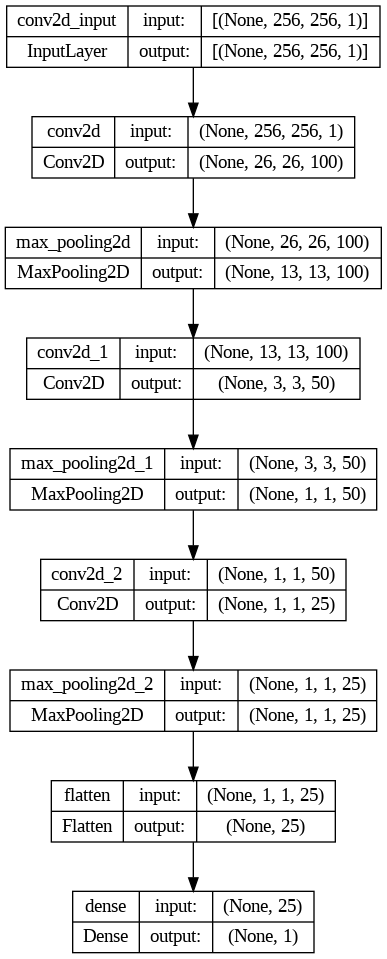

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
import pydot
import graphviz

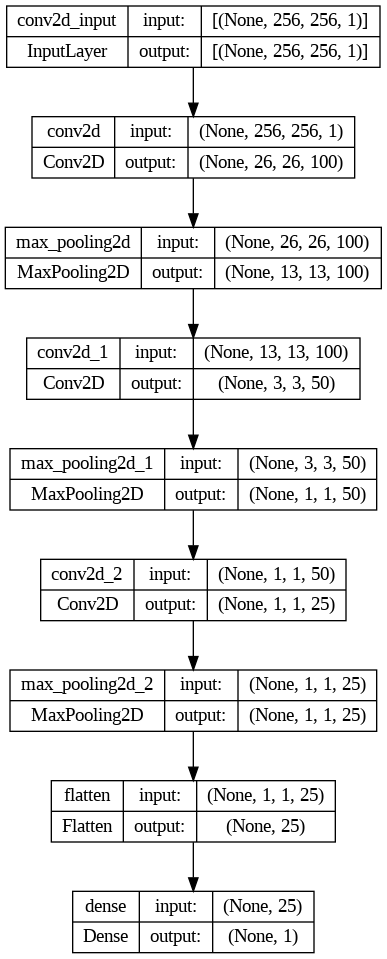

In [ ]:
plot_model(model, to_file='modelarch.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96)

**Accuracy, Recall & Precision**

In [ ]:
def get_metrics(model, X_test, y_test): 
    results = model.evaluate(X_test, y_test)
    accuracy = round(results[1]*100,2)
    y_pred = (model.predict(X_test) > 0.186685).astype("int32") 
    recall = round((recall_score(y_test, y_pred))*100, 2)
    precision = round(precision_score(y_test, y_pred)*100, 2)
    return accuracy, precision, recall

In [ ]:
model_accuracy, model_recall, model_precision = get_metrics(model, X_val, y_val)

1/1 [==============================] - 0s 137ms/step


In [ ]:
# Make predictions using the trained model
y_score = model.predict(X_test)
# Obtain true labels
y_true = y_test

2/2 [==============================] - 0s 12ms/step


In [ ]:
model_accuracy_cnn, model_recall_cnn, model_precision_cnn = get_metrics(model, X_test, y_test)

2/2 [==============================] - 0s 11ms/step


In [ ]:
model_accuracy_cnn, model_recall_cnn, model_precision_cnn = get_metrics(model, x_MRI_test, y_MRI_test)

1/1 [==============================] - 0s 475ms/step - loss: 0.4605 - accuracy: 0.8333


1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 110ms/step


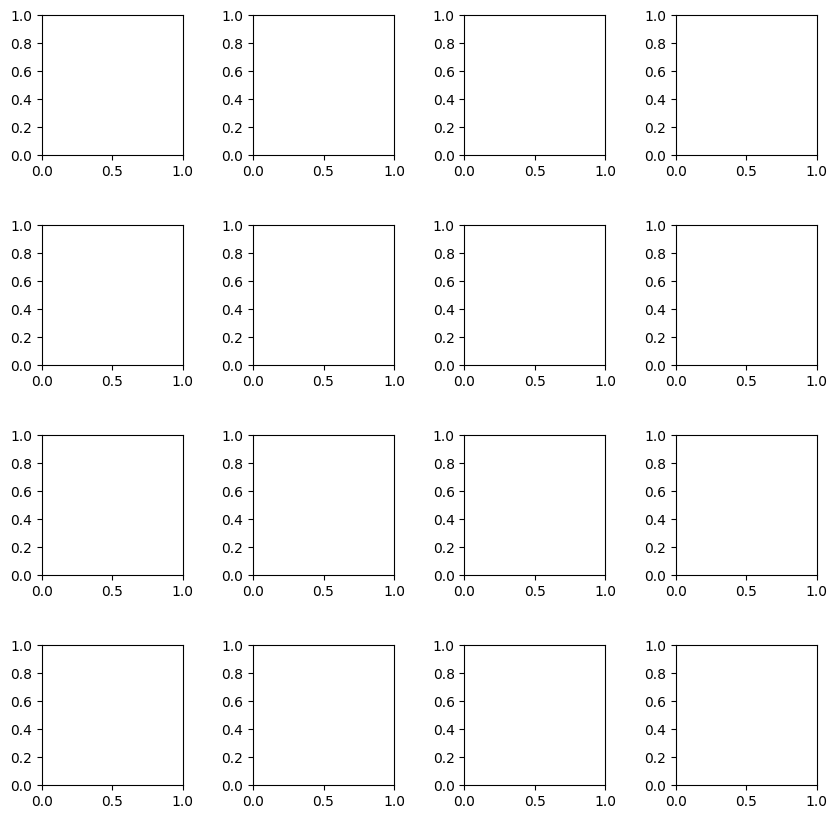

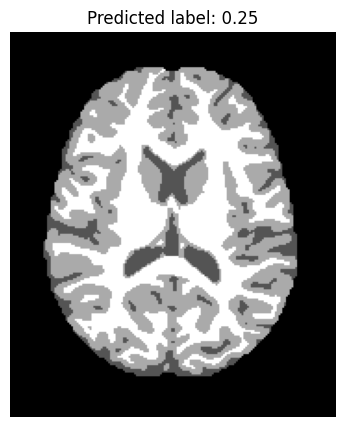

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the predicted labels for a set of test images
y_pred = model.predict(X_test)

# Plot some images along with their predicted labels
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
idx = np.random.randint(len(X_test))

# Get the predicted label for the selected image
label = y_pred[idx][0]

# Plot the selected image and its predicted label
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(X_test[idx].squeeze(), cmap='gray')
ax.set_title('Predicted label: {:.2f}'.format(float(label)))
ax.axis('off')

plt.show()











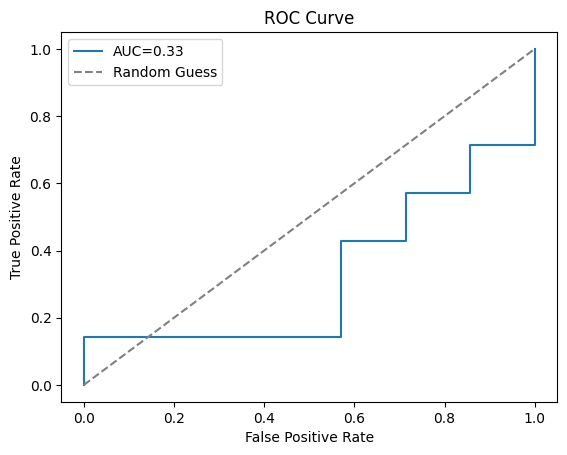

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# y_true: true binary labels
# y_score: predicted probabilities of positive class
auc_score = roc_auc_score(y_true, y_score)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC={auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
y_pred.size

21

**Testing CNN model with different Optimizers and Loss**

In [ ]:
input_shape = (256,256,1)

model2 = Sequential()
model2.add(Conv2D(100, kernel_size=(3, 3), strides=(10,10),
                 activation='sigmoid', padding ='same',
                 input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model2.add(Conv2D(50, (3, 3), activation='sigmoid', strides=(5,5), padding ='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model2.add(Conv2D(25, kernel_size=(3,3), activation='sigmoid', strides = (1,1), padding ='same'))
model2.add(MaxPooling2D(pool_size=(1, 1), padding='valid'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

EarlyStopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto') # stop when loss no longer improving

#model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])                           #Loss nan, Accuracy 72.73
#model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])                                       Loss 21.09, Accuracy 72.73
#model2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])                                      Loss 27.23, Accuracy 72.73
#model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])                                      Loss: 0.6125 - accuracy: 0.7273

model2.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adadelta(lr=0.0001, rho=0.95), metrics=['accuracy'])


model2.fit(X_train, y_train, epochs=100, batch_size=75, callbacks=[EarlyStopping])
model2.summary()

Epoch 1/100
1/1 [==============================] - 1s 943ms/step - loss: 0.5536 - accuracy: 0.7778
Epoch 2/100
1/1 [==============================] - 0s 146ms/step - loss: 0.5536 - accuracy: 0.7778
Epoch 3/100
1/1 [==============================] - 0s 161ms/step - loss: 0.5536 - accuracy: 0.7778
Epoch 4/100
1/1 [==============================] - 0s 148ms/step - loss: 0.5536 - accuracy: 0.7778
Epoch 5/100
1/1 [==============================] - 0s 137ms/step - loss: 0.5536 - accuracy: 0.7778
Epoch 6/100
1/1 [==============================] - 0s 163ms/step - loss: 0.5536 - accuracy: 0.7778
Epoch 7/100
1/1 [==============================] - 0s 164ms/step - loss: 0.5536 - accuracy: 0.7778
Epoch 8/100
1/1 [==============================] - 0s 164ms/step - loss: 0.5536 - accuracy: 0.7778
Epoch 9/100
1/1 [==============================] - 0s 172ms/step - loss: 0.5536 - accuracy: 0.7778
Epoch 10/100
1/1 [==============================] - 0s 156ms/step - loss: 0.5536 - accuracy: 0.7778
Epoch 11/

In [ ]:
model_accuracy, model_recall, model_precision = get_metrics(model2, X_val, y_val)

1/1 [==============================] - 0s 85ms/step


In [ ]:
model_accuracy, model_recall, model_precision = get_metrics(model2, X_test, y_test)

2/2 [==============================] - 0s 11ms/step


In [ ]:
model_accuracy, model_recall, model_precision = get_metrics(model2, x_MRI_test, y_MRI_test)

1/1 [==============================] - 0s 89ms/step


In [ ]:
model_accuracy, model_recall, model_precision = get_metrics(model2, X_val, y_val)

1/1 [==============================] - 0s 25ms/step


2/2 [==============================] - 0s 9ms/step


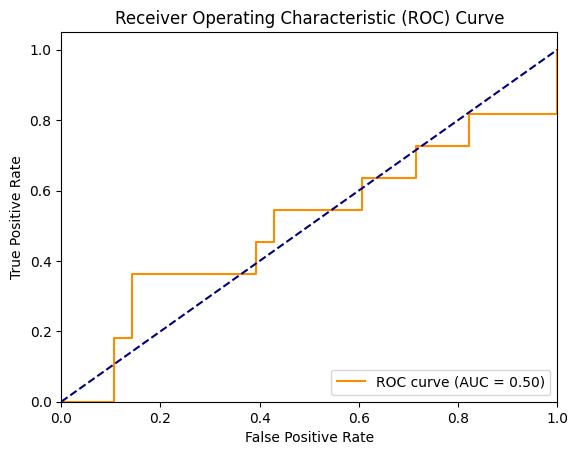

In [ ]:
from sklearn.metrics import roc_curve, auc

# Make predictions using your model
y_pred = model2.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Make predictions using the trained model
y_score2 = model2.predict(X_test)

# Obtain true labels
y_true = y_test


2/2 [==============================] - 0s 5ms/step


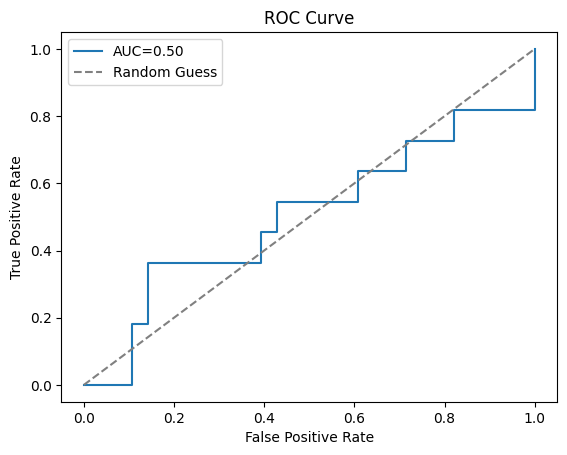

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# y_true: true binary labels
# y_score: predicted probabilities of positive class
auc_score = roc_auc_score(y_true, y_score2)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score2)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC={auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


**RNN Model**

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Define the number of timesteps and the number of features per timestep
timesteps = 208
input_dim = 176

# Define the model
RNNmodel = Sequential()

# Add a SimpleRNN layer with 64 hidden units
RNNmodel.add(SimpleRNN(units=64, input_shape=(timesteps, input_dim)))

# Add a fully connected output layer with a single output neuron
RNNmodel.add(Dense(units=1, activation='sigmoid'))

# Compile the model
RNNmodel.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Print the model summary
RNNmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                15424     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,489
Trainable params: 15,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RNNmodel.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
2/2 [==============================] - 1s 225ms/step - loss: 0.6480 - accuracy: 0.5246 - val_loss: 0.4334 - val_accuracy: 0.8519
Epoch 2/10
2/2 [==============================] - 0s 60ms/step - loss: 0.5133 - accuracy: 0.7869 - val_loss: 0.4512 - val_accuracy: 0.8519
Epoch 3/10
2/2 [==============================] - 0s 54ms/step - loss: 0.4959 - accuracy: 0.7869 - val_loss: 0.4363 - val_accuracy: 0.8519
Epoch 4/10
2/2 [==============================] - 0s 58ms/step - loss: 0.4928 - accuracy: 0.8197 - val_loss: 0.4223 - val_accuracy: 0.8519
Epoch 5/10
2/2 [==============================] - 0s 93ms/step - loss: 0.4986 - accuracy: 0.7869 - val_loss: 0.4304 - val_accuracy: 0.8519
Epoch 6/10
2/2 [==============================] - 0s 99ms/step - loss: 0.4667 - accuracy: 0.7705 - val_loss: 0.4442 - val_accuracy: 0.8519
Epoch 7/10
2/2 [==============================] - 0s 102ms/step - loss: 0.4432 - accuracy: 0.8197 - val_loss: 0.4315 - val_accuracy: 0.8519
Epoch 8/10
2/2 [=========

In [ ]:
test_loss, test_accuracy = RNNmodel.evaluate(X_test, y_test)

2/2 [==============================] - 0s 13ms/step - loss: 0.6568 - accuracy: 0.6667


In [ ]:
test_loss, test_accuracy = RNNmodel.evaluate(X_val, y_val)

1/1 [==============================] - 0s 30ms/step - loss: 0.4672 - accuracy: 0.8519


In [ ]:
test_loss, test_accuracy = RNNmodel.evaluate(x_MRI_test, y_MRI_test)

1/1 [==============================] - 0s 228ms/step - loss: 0.6716 - accuracy: 0.6923


2/2 [==============================] - 0s 10ms/step


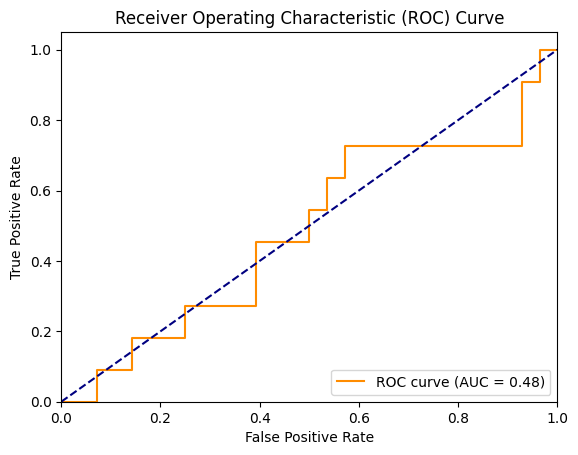

In [ ]:
# Make predictions using your model
y_pred = RNNmodel.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import tensorflow as tf
input_shape = (256,256,1)

model3 = Sequential()
model3.add(Conv2D(100, kernel_size=(3, 3), strides=(10,10), activation=tf.keras.layers.Activation('tanh'), padding ='same', input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model3.add(Conv2D(50, (3, 3), activation=tf.keras.layers.Activation('tanh'), strides=(5,5), padding ='same'))
model3.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model3.add(Conv2D(25, kernel_size=(3,3), activation=tf.keras.layers.Activation('tanh'), strides = (1,1), padding ='same'))
model3.add(MaxPooling2D(pool_size=(1, 1), padding='valid'))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

EarlyStopping = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=0, mode='auto') # stop when loss no longer improving

adam = keras.optimizers.Adam(lr=0.0001)
model3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model3.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[EarlyStopping])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - ETA: 0s - loss: 0.7236 - accuracy: 0.2188

1/1 [==============================] - 1s 987ms/step - loss: 0.7236 - accuracy: 0.2188 - val_loss: 0.7148 - val_accuracy: 0.2500
Epoch 2/100
1/1 [==============================] - 0s 120ms/step - loss: 0.7157 - accuracy: 0.2188 - val_loss: 0.7081 - val_accuracy: 0.2500
Epoch 3/100
1/1 [==============================] - 0s 159ms/step - loss: 0.7086 - accuracy: 0.2188 - val_loss: 0.7016 - val_accuracy: 0.2500
Epoch 4/100
1/1 [==============================] - 0s 119ms/step - loss: 0.7024 - accuracy: 0.2188 - val_loss: 0.6959 - val_accuracy: 0.3750
Epoch 5/100
1/1 [==============================] - 0s 119ms/step - loss: 0.6971 - accuracy: 0.2656 - val_loss: 0.6909 - val_accuracy: 0.7500
Epoch 6/100
1/1 [==============================] - 0s 132ms/step - loss: 0.6923 - accuracy: 0.5625 - val_loss: 0.6864 - val_accuracy: 0.7500
Epoch 7/100
1/1 [==============================] - 0s 127ms/step - loss: 0.6878 - accuracy: 0.7812 - val_loss: 0.6821 - val_accuracy: 0.7500
Epoch 8/100
1/1 [========

In [ ]:
test_loss, test_accuracy = model3.evaluate(X_val, y_val)

1/1 [==============================] - 0s 37ms/step - loss: 0.5733 - accuracy: 0.8387


In [ ]:
test_loss, test_accuracy = model3.evaluate(x_MRI_test, y_MRI_test)

1/1 [==============================] - 0s 347ms/step - loss: 0.6726 - accuracy: 0.8333


In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cv2

# Initialize an empty numpy array to store RGB images
rgb_array = np.empty((brain_array.shape[0], brain_array.shape[1], brain_array.shape[2], 3))

# Loop through each grayscale image and convert to RGB format
for i in range(brain_array.shape[0]):
    img = cv2.cvtColor(brain_array[i], cv2.COLOR_GRAY2RGB)
    rgb_array[i] = img

# Print shape of the new RGB array
print("Shape of RGB array:", rgb_array.shape)


Shape of RGB array: (148, 256, 256, 3)


In [ ]:
# Split the data into training and testing sets
X_trainrgb, X_testrgb, y_trainrgb, y_testrgb = train_test_split(rgb_array, subjects['Diagnosis'][:148], test_size=0.2, random_state=42)

# Split the training data further into training and validation sets
X_trainrgb, X_valrgb, y_trainrgb, y_valrgb = train_test_split(X_trainrgb, y_trainrgb, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
# Load the pre-trained ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Create a new model based on ResNet50
resnetmodel = Sequential()
resnetmodel.add(resnet)
resnetmodel.add(Flatten())
resnetmodel.add(Dense(1, activation='sigmoid'))

# Compile the model
resnetmodel.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
resnetmodel.summary()

94765736/94765736 [==============================] - 3s 0us/step


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 dense_7 (Dense)             (None, 1)                 131073    
                                                                 
Total params: 23,718,785
Trainable params: 23,665,665
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
test_loss, test_acc = resnetmodel.evaluate(X_valrgb, y_valrgb)
print('Test accuracy:', test_acc)

1/1 [==============================] - 8s 8s/step - loss: 1.6629 - accuracy: 0.4583
Test accuracy: 0.4583333432674408


In [ ]:
test_loss, test_acc = resnetmodel.evaluate(X_testrgb, y_testrgb)
print('Test accuracy:', test_acc)

1/1 [==============================] - 8s 8s/step - loss: 0.6053 - accuracy: 0.7667
Test accuracy: 0.7666666507720947


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Create a new model based on VGG16
vggmodel = Sequential()
vggmodel.add(vgg)
vggmodel.add(Flatten())
vggmodel.add(Dense(1, activation='sigmoid'))

# Compile the model
vggmodel.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
vggmodel.summary()


58889256/58889256 [==============================] - 0s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 14,747,457
Trainable params: 14,747,457
Non-trainable params: 0
_________________________________________________________________


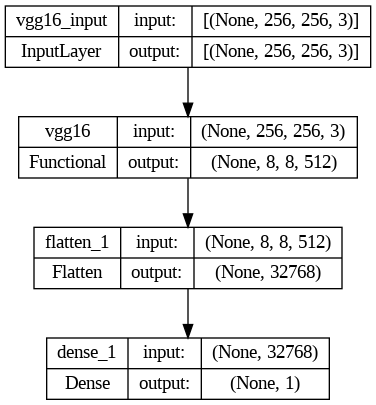

In [ ]:
plot_model(vggmodel, to_file='vggmodelarch.png', show_shapes=True, show_layer_names=True)

In [ ]:
test_loss, test_acc = vggmodel.evaluate(X_valrgb, y_valrgb)
print('Test accuracy:', test_acc)




1/1 [==============================] - 21s 21s/step - loss: 3.7264 - accuracy: 0.4583
Test accuracy: 0.4583333432674408


In [ ]:
test_loss, test_acc = resnetmodel.evaluate(X_testrgb, y_testrgb)
print('Test accuracy:', test_acc)

1/1 [==============================] - 9s 9s/step - loss: 0.6053 - accuracy: 0.7667
Test accuracy: 0.7666666507720947


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D


# Load the pre-trained InceptionV3 model
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(208,176,3))

# Create a new model based on InceptionV3
inceptionmodel = Sequential()
inceptionmodel.add(inception)
inceptionmodel.add(GlobalAveragePooling2D())
inceptionmodel.add(Dense(1, activation='sigmoid'))

# Compile the model
inceptionmodel.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
inceptionmodel.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_11 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
test_loss, test_acc = inceptionmodel.evaluate(X_valrgb, y_valrgb)
print('Test accuracy:', test_acc)

test_loss, test_acc = inceptionmodel.evaluate(X_testrgb, y_testrgb)
print('Test accuracy:', test_acc)


1/1 [==============================] - 6s 6s/step - loss: 13.3981 - accuracy: 0.7273
Test accuracy: 0.7272727489471436
1/1 [==============================] - 2s 2s/step - loss: 24.8114 - accuracy: 0.5000
Test accuracy: 0.5


In [ ]:

test = pd.read_csv("/content/drive/MyDrive/oasis_cross-sectional.csv")
test.head()


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [ ]:
test['CDR'].value_counts()

0.0    135
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

In [ ]:
test['Delay'].isna().sum()

416

In [ ]:
test.size


5232

In [ ]:
test['Delay'].fillna(test['Delay'].mean(),inplace=True)
test['Delay']

0      20.55
1      20.55
2      20.55
3      20.55
4      20.55
       ...  
431     2.00
432    40.00
433    89.00
434     2.00
435    39.00
Name: Delay, Length: 436, dtype: float64

# lets conduct a time series analysis 

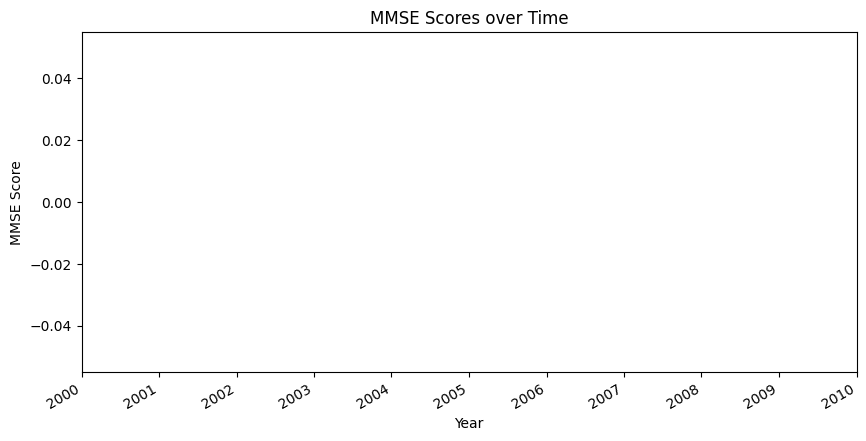

In [ ]:
test['DelayTime'] = pd.to_datetime(test['Delay'])

# Set the "Delay" column as the index
test.set_index('Delay', inplace=True)

# Plot the MMSE scores over time
test['MMSE'].plot(figsize=(10,5), title='MMSE Scores over Time')
plt.xlabel('Year')
plt.ylabel('MMSE Score')
plt.show()

In [ ]:
test['Delay'].value_counts()

KeyError: ignored